Imports and definitions

In [104]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tensorflow as tf
import cv2
import tqdm
from sklearn.preprocessing import LabelBinarizer
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
import datetime

plt.ion() 
#this transform will be used also for video frames
test_transf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#mean and std from imagenet of rgb channels
]);
# Data augmentation and normalization for training
# Just normalization for validation
#Images are 224,224,3 jpg
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': test_transf
}

data_dir = 'D:/Drive/ML/sport_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#method to call after cnn model provides output
normalizeResult = nn.Softmax(dim=1)

#this is an imshow method for the result tensor on CNN models, it is needed to invert the transformation 
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #track time

    best_model_wts = copy.deepcopy(model.state_dict()) #it will contain the best weights
    best_acc = 0.0 # best accuracy
    best_loss = 1000
    best_epoch = 0
    
    acc_train = []
    acc_test = []
    loss_train = []
    loss_test = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients every epoch so the gradient follows weights and biases of the current epoch only
                optimizer.zero_grad()

                # forward
                # track history (gradient) if only in train 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics, summing to get the mean for each epoch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() #eventually update learning rate

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()
            
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_test.append(epoch_acc)
                loss_test.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and (epoch_acc > best_acc or (epoch_acc == best_acc and epoch_loss < best_loss)):
                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch: {}'.format(best_epoch))
    print('Best test Acc: {:4f}'.format(best_acc))
    print('Best test Loss: {:4f}'.format(best_loss))
    
    fig, ax = plt.subplots()
    x = np.arange(0, num_epochs, 1)
    ax.plot(x, acc_train, 'ro-', label='Train accuracy')
    ax.plot(x, acc_test, 'go-', label='Test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    leg = ax.legend()
    
    fig, ax = plt.subplots()
    ax.plot(x, loss_train, 'yo-', label='Train loss')
    ax.plot(x, loss_test, 'ko-', label='Test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    leg = ax.legend()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# get predicted and ground truth labels for CNNs
def getAnalysisData(model, setType):
    pred_labels = []
    ground_truth = []

    for i, (inputs, labels) in enumerate(dataloaders[setType]):
        model.eval()
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            res = normalizeResult(outputs)
            conf, predicted = torch.max(res, 1)

            pred_labels.extend(predicted.detach().cpu().numpy().flatten().tolist())
            ground_truth.extend(labels.detach().cpu().numpy().flatten().tolist())

    return pred_labels,ground_truth

#print precision,accuracy,recall and confusion matrix
def analysis(pred_labels,ground_truth):
    accuracy = accuracy_score(ground_truth, pred_labels)
    print('Accuracy: {}'.format(accuracy))

    precision = precision_score(ground_truth, pred_labels, average='weighted')
    print('Precision: {}'.format(precision))

    recall = recall_score(ground_truth, pred_labels, average='weighted')
    print('Recall: {}'.format(recall))

    cm = confusion_matrix(ground_truth, pred_labels)
    disp = ConfusionMatrixDisplay(cm, display_labels = class_names)
    #fig = plt.figure(figsize=(20, 20))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    disp.plot(ax = ax,xticks_rotation='vertical')
    
    print(classification_report(ground_truth, pred_labels, digits=3, target_names=class_names))

# a method to see some random result
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            res = normalizeResult(outputs)
            conf, preds = torch.max(res, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                ax.set_title('predicted: {}, confidence: {}'.format(class_names[preds[j]], conf[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
def frame_extractor(videoPath, saveFolder, classToFind, model, threshold = 0.5, desiredFps = 10, print_perc = 5):
    if not os.path.exists(saveFolder):
        os.makedirs(saveFolder)

    result = []

    cap = cv2.VideoCapture(videoPath)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('Total frames: {}'.format(num_frames))
    sample_every_frame = int(cap.get(cv2.CAP_PROP_FPS)/desiredFps)
    current_frame = 0
    print_step = int(num_frames/(100/print_perc))
    max_images = int(num_frames/sample_every_frame)

    font = cv2.FONT_HERSHEY_SIMPLEX

    os.chdir(saveFolder)

    model.eval()
    with torch.no_grad():
        while True:
            success, image = cap.read()
            #print(success)
            if not success:
                continue

            if current_frame % sample_every_frame == 0:
                # OPENCV reads in BGR, tensorflow expects RGB so we invert the order
                max_images -= 1
                frame = image[:, :, ::-1]
                frame = Image.fromarray(frame)
                frame = test_transf(frame)
                frame = frame.unsqueeze(0).to(device)

                outputs = model(frame)
                res = normalizeResult(outputs)
                conf, preds = torch.max(res, 1)
                if preds == classToFind and res[0,classToFind] > threshold:

                    conf = conf.cpu().detach().numpy()[0]
                    timestamp = datetime.timedelta(milliseconds = cap.get(cv2.CAP_PROP_POS_MSEC))
                    cv2.putText(image, 'Confidence: {}'.format(conf), (100, 100), font, 3, (0, 255, 255),2,4)
                    cv2.putText(image, 'Time: {}'.format(timestamp), (100, 200), font, 3, (0, 255, 255),2,4)
                    cv2.imwrite('frame_{}.jpg'.format(current_frame),image)
                    result.append([timestamp.__str__(), conf])
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    plt.imshow(image)
                    plt.show()

                    #print('Confidence: {} at time: {}'.format(conf, timestamp))

                #frames = torch.cat((frames, frame), 0)

            if max_images == 0:
                print('progress: 100%')
                break
            current_frame += 1
            if current_frame % print_step == 0:
                print('progress: {}%'.format(print_perc*current_frame/print_step))
            #print(max_images,current_frame)
        return result


CNN models

In [105]:
#fine tune model, replace last layer and let feedback 
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

In [12]:
model_ft.load_state_dict(torch.load(data_dir+'/model_ft_min'))

<All keys matched successfully>

Epoch 0/29
----------
train Loss: 2.4411 Acc: 0.3082
test Loss: 1.3305 Acc: 0.6389

Epoch 1/29
----------
train Loss: 1.7076 Acc: 0.5529
test Loss: 0.6373 Acc: 0.8444

Epoch 2/29
----------
train Loss: 1.3334 Acc: 0.6532
test Loss: 0.3829 Acc: 0.9167

Epoch 3/29
----------
train Loss: 1.1308 Acc: 0.6962
test Loss: 0.2540 Acc: 0.9389

Epoch 4/29
----------
train Loss: 1.0341 Acc: 0.7126
test Loss: 0.2006 Acc: 0.9611

Epoch 5/29
----------
train Loss: 0.9376 Acc: 0.7352
test Loss: 0.1636 Acc: 0.9833

Epoch 6/29
----------
train Loss: 0.8673 Acc: 0.7564
test Loss: 0.1314 Acc: 0.9722

Epoch 7/29
----------
train Loss: 0.8358 Acc: 0.7626
test Loss: 0.1283 Acc: 0.9833

Epoch 8/29
----------
train Loss: 0.7927 Acc: 0.7808
test Loss: 0.1166 Acc: 0.9778

Epoch 9/29
----------
train Loss: 0.8231 Acc: 0.7717
test Loss: 0.1184 Acc: 0.9778

Epoch 10/29
----------
train Loss: 0.7980 Acc: 0.7779
test Loss: 0.1102 Acc: 0.9722

Epoch 11/29
----------
train Loss: 0.8190 Acc: 0.7794
test Loss: 0.1129 Acc

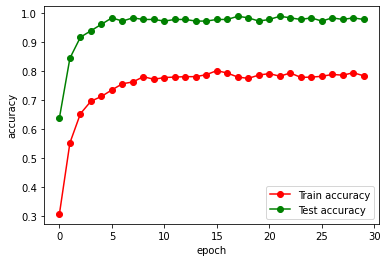

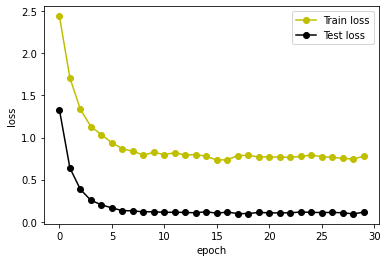

In [106]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)
torch.save(model_ft.state_dict(), data_dir+'/model_ft_min')

In [107]:
#feature extraction only, replace last layer and do not let feedback 
model_fe = models.resnet18(pretrained=True)
for param in model_fe.parameters():
    param.requires_grad = False
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, len(class_names))
model_fe = model_fe.to(device)


In [14]:
model_fe.load_state_dict(torch.load(data_dir+'/model_fe_min'))

<All keys matched successfully>

Epoch 0/29
----------
train Loss: 2.6599 Acc: 0.1900
test Loss: 1.9946 Acc: 0.4556

Epoch 1/29
----------
train Loss: 2.1999 Acc: 0.4012
test Loss: 1.4276 Acc: 0.6944

Epoch 2/29
----------
train Loss: 1.9258 Acc: 0.4916
test Loss: 1.0090 Acc: 0.8278

Epoch 3/29
----------
train Loss: 1.7383 Acc: 0.5697
test Loss: 0.8738 Acc: 0.8111

Epoch 4/29
----------
train Loss: 1.5937 Acc: 0.5977
test Loss: 0.6716 Acc: 0.8556

Epoch 5/29
----------
train Loss: 1.4365 Acc: 0.6524
test Loss: 0.5191 Acc: 0.9444

Epoch 6/29
----------
train Loss: 1.3985 Acc: 0.6499
test Loss: 0.4587 Acc: 0.9333

Epoch 7/29
----------
train Loss: 1.3462 Acc: 0.6769
test Loss: 0.4770 Acc: 0.9333

Epoch 8/29
----------
train Loss: 1.3362 Acc: 0.6736
test Loss: 0.4782 Acc: 0.9167

Epoch 9/29
----------
train Loss: 1.3178 Acc: 0.6758
test Loss: 0.5222 Acc: 0.9056

Epoch 10/29
----------
train Loss: 1.3352 Acc: 0.6663
test Loss: 0.4553 Acc: 0.9333

Epoch 11/29
----------
train Loss: 1.3083 Acc: 0.6681
test Loss: 0.4319 Acc

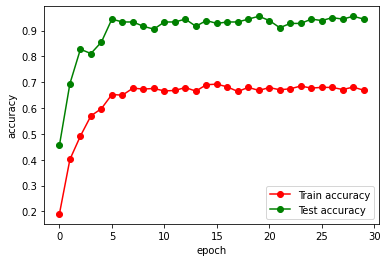

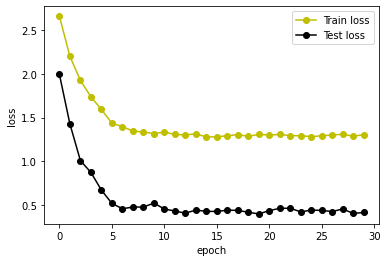

In [108]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_fe = optim.SGD(model_fe.parameters(), lr=0.0001, momentum=0.9)
# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fe, step_size=7, gamma=0.1)

model_fe = train_model(model_fe, criterion, optimizer_fe, exp_lr_scheduler,
                       num_epochs=30)
torch.save(model_fe.state_dict(), data_dir+'/model_fe_min')

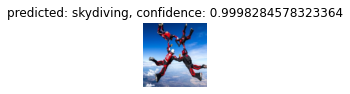

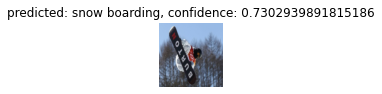

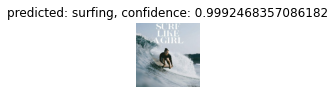

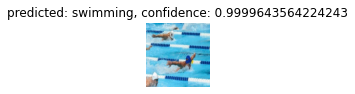

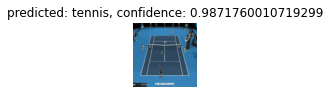

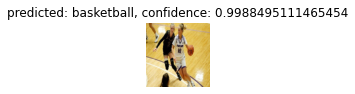

In [94]:
visualize_model(model_ft)

Script for frame extraction

Accuracy: 0.9888888888888889
Precision: 0.9907407407407408
Recall: 0.9888888888888889
                   precision    recall  f1-score   support

         baseball      1.000     1.000     1.000        10
       basketball      1.000     1.000     1.000        10
              bmx      1.000     1.000     1.000        10
         football      1.000     1.000     1.000        10
 formula 1 racing      1.000     1.000     1.000        10
          frisbee      1.000     0.900     0.947        10
             golf      1.000     1.000     1.000        10
           hockey      1.000     1.000     1.000        10
motorcycle racing      1.000     1.000     1.000        10
            rugby      1.000     1.000     1.000        10
        skydiving      1.000     1.000     1.000        10
    snow boarding      1.000     1.000     1.000        10
   sumo wrestling      1.000     1.000     1.000        10
          surfing      1.000     1.000     1.000        10
         swimming      1.000

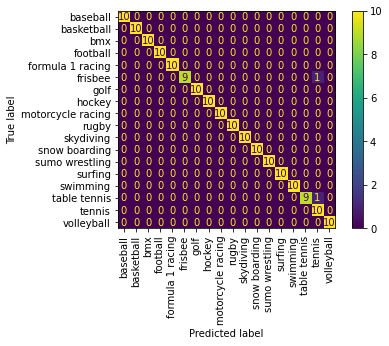

In [109]:
pred_labels, ground_truth = getAnalysisData(model_ft, 'test')
analysis(pred_labels, ground_truth)

Accuracy: 0.8964259664478483
Precision: 0.8991712833236045
Recall: 0.8964259664478483
                   precision    recall  f1-score   support

         baseball      0.901     0.839     0.869       174
       basketball      0.802     0.864     0.832       169
              bmx      0.889     0.914     0.901       140
         football      0.910     0.848     0.878       191
 formula 1 racing      0.959     0.979     0.969       191
          frisbee      0.791     0.880     0.833       133
             golf      0.906     0.796     0.847       157
           hockey      0.879     0.971     0.923       172
motorcycle racing      0.890     0.917     0.903       132
            rugby      0.919     0.892     0.905       166
        skydiving      0.972     0.946     0.959       149
    snow boarding      0.926     0.855     0.889       117
   sumo wrestling      0.939     0.932     0.936       133
          surfing      0.978     0.944     0.961       142
         swimming      0.974

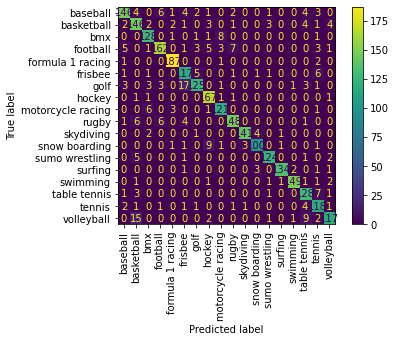

In [110]:
pred_labels, ground_truth = getAnalysisData(model_ft, 'train')
analysis(pred_labels, ground_truth)

Accuracy: 0.9555555555555556
Precision: 0.9621989121989123
Recall: 0.9555555555555556
                   precision    recall  f1-score   support

         baseball      0.900     0.900     0.900        10
       basketball      1.000     0.900     0.947        10
              bmx      1.000     0.900     0.947        10
         football      0.909     1.000     0.952        10
 formula 1 racing      0.909     1.000     0.952        10
          frisbee      1.000     0.900     0.947        10
             golf      1.000     1.000     1.000        10
           hockey      1.000     1.000     1.000        10
motorcycle racing      0.909     1.000     0.952        10
            rugby      1.000     1.000     1.000        10
        skydiving      1.000     1.000     1.000        10
    snow boarding      1.000     1.000     1.000        10
   sumo wrestling      1.000     1.000     1.000        10
          surfing      1.000     1.000     1.000        10
         swimming      1.000

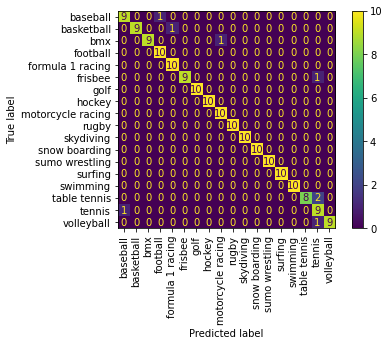

In [111]:
pred_labels, ground_truth = getAnalysisData(model_fe, 'test')
analysis(pred_labels, ground_truth)

Accuracy: 0.8143690736688548
Precision: 0.8149001121787629
Recall: 0.8143690736688548
                   precision    recall  f1-score   support

         baseball      0.733     0.724     0.728       174
       basketball      0.762     0.680     0.719       169
              bmx      0.847     0.829     0.838       140
         football      0.760     0.780     0.770       191
 formula 1 racing      0.839     0.958     0.895       191
          frisbee      0.762     0.722     0.741       133
             golf      0.783     0.713     0.747       157
           hockey      0.830     0.907     0.867       172
motorcycle racing      0.855     0.848     0.852       132
            rugby      0.815     0.825     0.820       166
        skydiving      0.820     0.946     0.879       149
    snow boarding      0.893     0.641     0.746       117
   sumo wrestling      0.843     0.887     0.864       133
          surfing      0.802     0.944     0.867       142
         swimming      0.895

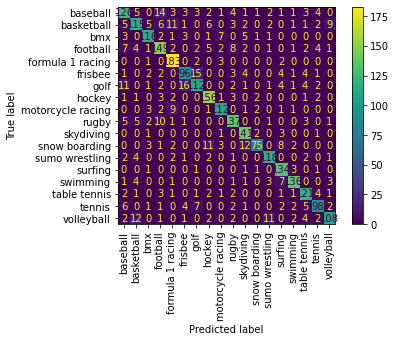

In [112]:
pred_labels, ground_truth = getAnalysisData(model_fe, 'train')
analysis(pred_labels, ground_truth)

In [113]:
class_names

['baseball',
 'basketball',
 'bmx',
 'football',
 'formula 1 racing',
 'frisbee',
 'golf',
 'hockey',
 'motorcycle racing',
 'rugby',
 'skydiving',
 'snow boarding',
 'sumo wrestling',
 'surfing',
 'swimming',
 'table tennis',
 'tennis',
 'volleyball']

Total frames: 17338


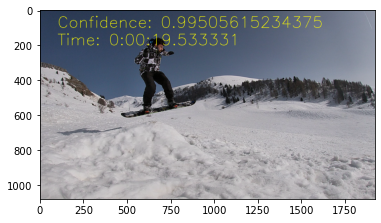

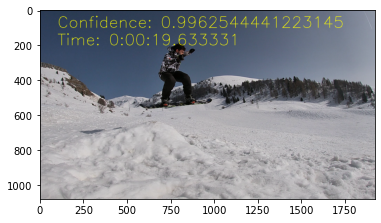

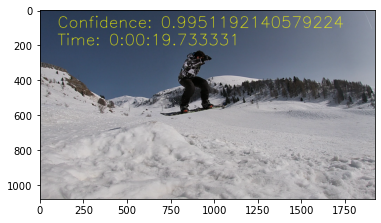

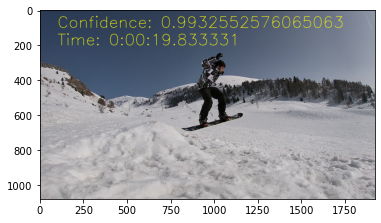

progress: 5.0%
progress: 10.0%
progress: 15.0%
progress: 20.0%
progress: 25.0%
progress: 30.0%
progress: 35.0%
progress: 40.0%


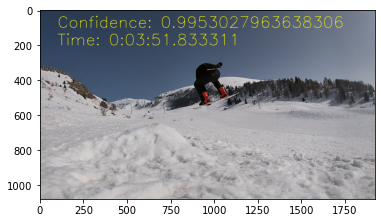

progress: 45.0%
progress: 50.0%
progress: 55.0%
progress: 60.0%
progress: 65.0%
progress: 70.0%


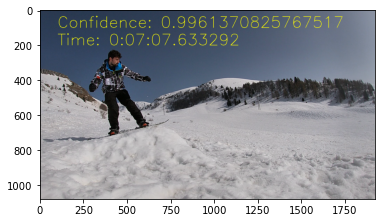

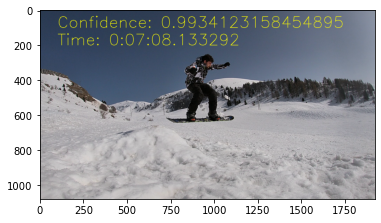

progress: 75.0%
progress: 80.0%


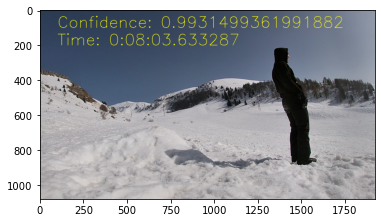

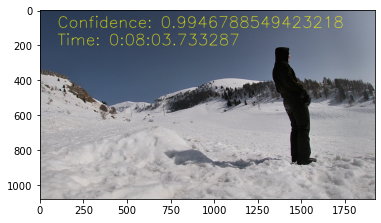

progress: 85.0%
progress: 90.0%
progress: 95.0%
progress: 100.0%
progress: 100%


In [116]:
snowFtResult = frame_extractor('D:/snowboard/GH020473_up.MP4', 'D:/snowboard/test_snow_ft_min', 11, model_ft, threshold = 0.993)

Total frames: 17338


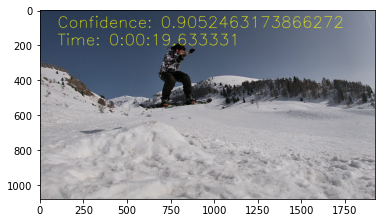

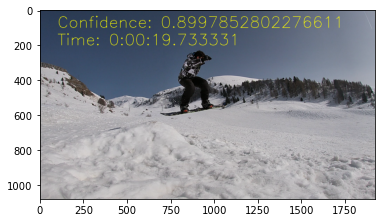

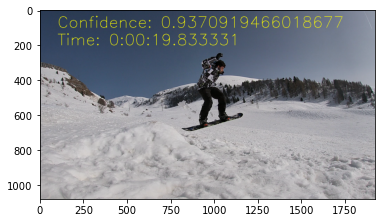

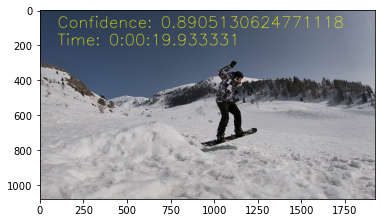

progress: 5.0%
progress: 10.0%
progress: 15.0%
progress: 20.0%
progress: 25.0%
progress: 30.0%
progress: 35.0%
progress: 40.0%


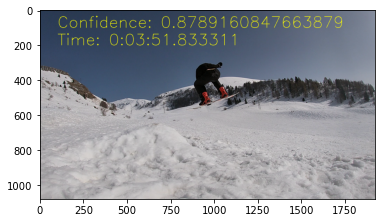

progress: 45.0%
progress: 50.0%
progress: 55.0%
progress: 60.0%
progress: 65.0%
progress: 70.0%


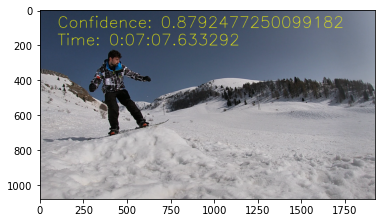

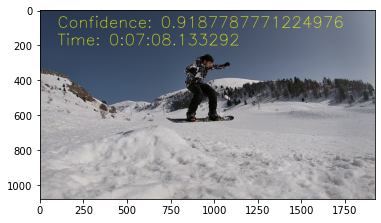

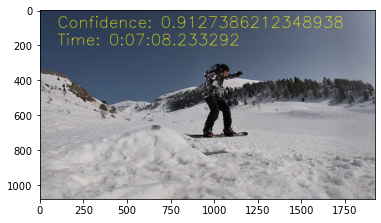

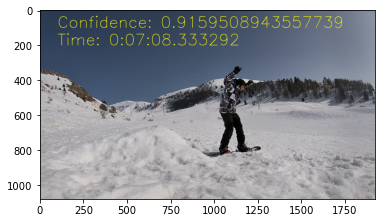

progress: 75.0%


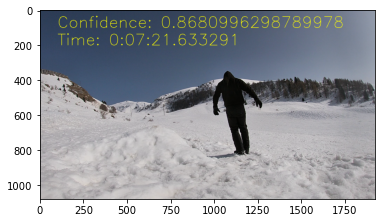

progress: 80.0%


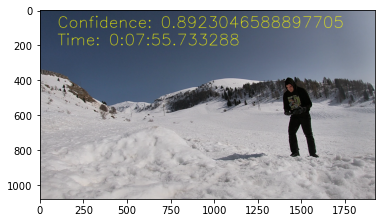

progress: 85.0%
progress: 90.0%
progress: 95.0%
progress: 100.0%
progress: 100%


In [119]:
snowFeResult = frame_extractor('D:/snowboard/GH020473_up.MP4', 'D:/snowboard/test_snow_fe_min', 11, model_fe, threshold = 0.85)

In [ ]:
pitFtResult = frame_extractor('D:/pit_static.MOV', 'D:/pit_static_frames', 8, model_ft, threshold = 0.5)

In [121]:
pitFtResult

[['0:01:54.033333', 0.70745146],
 ['0:04:58.233333', 0.7815125],
 ['0:05:15.233333', 0.6939066],
 ['0:05:17.533333', 0.50233245],
 ['0:05:18.133333', 0.5358754],
 ['0:05:18.433333', 0.6619607],
 ['0:05:18.533333', 0.6510301],
 ['0:05:18.633333', 0.5728035],
 ['0:05:18.733333', 0.58838457],
 ['0:05:18.833333', 0.6025124],
 ['0:05:18.933333', 0.70310706],
 ['0:05:19.033333', 0.7178189],
 ['0:05:19.133333', 0.7194696],
 ['0:05:19.233333', 0.6810907],
 ['0:05:19.333333', 0.65987504],
 ['0:05:19.433333', 0.59949654],
 ['0:05:19.533333', 0.56941813],
 ['0:05:19.633333', 0.64258146],
 ['0:05:19.733333', 0.6617167],
 ['0:05:19.833333', 0.54027575],
 ['0:05:20.733333', 0.66196734],
 ['0:05:20.833333', 0.722043],
 ['0:05:20.933333', 0.52739525],
 ['0:05:21.033333', 0.55343914],
 ['0:09:47.233333', 0.54935724],
 ['0:09:49.933333', 0.5196835],
 ['0:09:50.133333', 0.6697149],
 ['0:09:50.233333', 0.50541544],
 ['0:09:50.333333', 0.6105455],
 ['0:09:51.433333', 0.6937034],
 ['0:09:51.633333', 0.53396

Prepare data for other models

In [122]:
from sklearn.decomposition import PCA
from glob import iglob
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

images = []
train_labels = []
for path in iglob(data_dir+'/train/*/*.jpg'):
    img = np.asarray(Image.open(path).convert('L'),dtype=np.uint).flatten()
    label = class_names.index(os.path.basename(os.path.dirname(path)))
    train_labels.append(label)
    images.append(img)
images = np.array(scaler.fit_transform(images))


In [123]:
pca = PCA(n_components=0.8) #80% explained variance
pca.fit(images) #this takes a lot

PCA(n_components=0.8)

189


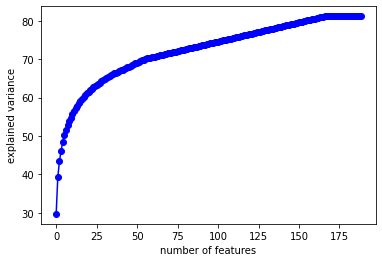

In [128]:
explainedVariance=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
fig, ax = plt.subplots()
x = np.arange(0, len(explainedVariance), 1)
ax.plot(x, explainedVariance, 'bo-')
plt.xlabel('number of features')
plt.ylabel('explained variance')
print(pca.n_components_)

In [129]:
trainImages = pca.transform(images) 
torch.save([trainImages, pca],data_dir+'/pcaData')

In [70]:
import torch
trainImages, pca = torch.load(data_dir+'/pcaData')

In [130]:
test_images = []
test_labels = []
from glob import iglob
for path in iglob(data_dir+'/test/*/*.jpg'):
    img = np.asarray(Image.open(path).convert('L'),dtype=np.uint).flatten()
    label = class_names.index(os.path.basename(os.path.dirname(path)))
    test_labels.append(label)
    test_images.append(img)
test_images = np.array(scaler.transform(test_images))
testImages = pca.transform(test_images)

Other models

In [131]:
from sklearn.svm import SVC
#one vs one svc
kernel = 'rbf'
max_iteration = 1000 
svcModelOvo = SVC(kernel=kernel, max_iter=max_iteration, probability=True, decision_function_shape='ovo')
svcModelOvo.fit(trainImages,train_labels)


SVC(decision_function_shape='ovo', max_iter=1000, probability=True)

Accuracy: 0.3888888888888889
Precision: 0.4183707187873855
Recall: 0.3888888888888889
                   precision    recall  f1-score   support

         baseball      0.200     0.200     0.200        10
       basketball      0.273     0.300     0.286        10
              bmx      0.500     0.200     0.286        10
         football      0.188     0.300     0.231        10
 formula 1 racing      0.538     0.700     0.609        10
          frisbee      0.500     0.100     0.167        10
             golf      0.600     0.300     0.400        10
           hockey      0.625     1.000     0.769        10
motorcycle racing      0.571     0.400     0.471        10
            rugby      0.200     0.300     0.240        10
        skydiving      0.455     0.500     0.476        10
    snow boarding      0.500     0.300     0.375        10
   sumo wrestling      0.444     0.400     0.421        10
          surfing      0.545     0.600     0.571        10
         swimming      0.280

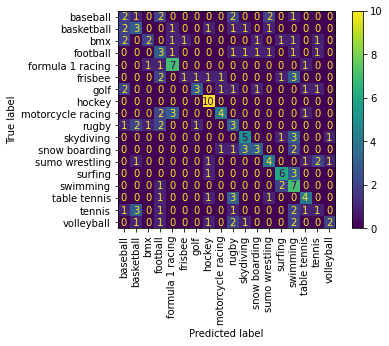

In [134]:
predicted_test = svcModelOvo.predict(testImages)
analysis(predicted_test,test_labels)

Accuracy: 0.6108679795769512
Precision: 0.6415893822419315
Recall: 0.6108679795769512
                   precision    recall  f1-score   support

         baseball      0.503     0.552     0.526       174
       basketball      0.622     0.740     0.676       169
              bmx      0.673     0.529     0.592       140
         football      0.536     0.628     0.578       191
 formula 1 racing      0.611     0.848     0.711       191
          frisbee      0.941     0.241     0.383       133
             golf      0.795     0.420     0.550       157
           hockey      0.761     0.890     0.820       172
motorcycle racing      0.782     0.598     0.678       132
            rugby      0.519     0.657     0.580       166
        skydiving      0.585     0.530     0.556       149
    snow boarding      0.709     0.624     0.664       117
   sumo wrestling      0.736     0.714     0.725       133
          surfing      0.638     0.669     0.653       142
         swimming      0.455

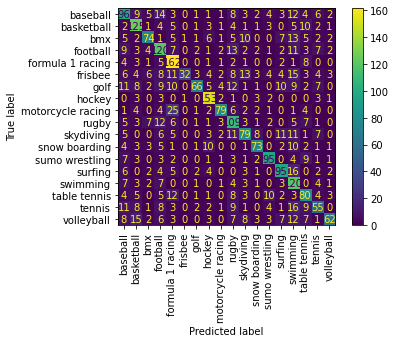

In [133]:
predicted_train = svcModelOvo.predict(trainImages)
analysis(predicted_train,train_labels)

In [135]:
from sklearn.svm import SVC

kernel = 'rbf'
max_iteration = 1000 
svcModel = SVC(kernel=kernel, max_iter=max_iteration, probability=True) #by default one vs rest
svcModel.fit(trainImages,train_labels)


SVC(max_iter=1000, probability=True)

Accuracy: 0.3888888888888889
Precision: 0.4192055698556124
Recall: 0.3888888888888889
                   precision    recall  f1-score   support

         baseball      0.182     0.200     0.190        10
       basketball      0.182     0.200     0.190        10
              bmx      0.500     0.200     0.286        10
         football      0.235     0.400     0.296        10
 formula 1 racing      0.538     0.700     0.609        10
          frisbee      0.500     0.100     0.167        10
             golf      0.600     0.300     0.400        10
           hockey      0.625     1.000     0.769        10
motorcycle racing      0.571     0.400     0.471        10
            rugby      0.200     0.300     0.240        10
        skydiving      0.556     0.500     0.526        10
    snow boarding      0.400     0.400     0.400        10
   sumo wrestling      0.400     0.400     0.400        10
          surfing      0.545     0.600     0.571        10
         swimming      0.261

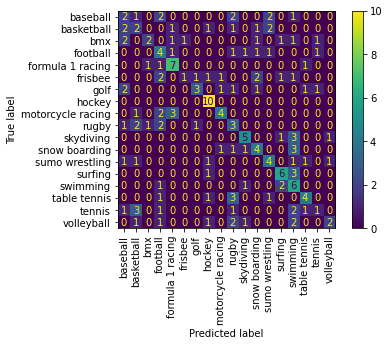

In [137]:
res = svcModel.predict_proba(testImages)
predicted = np.argmax(res,axis=1)
analysis(predicted,test_labels)

Accuracy: 0.6159737417943107
Precision: 0.6367083464026628
Recall: 0.6159737417943107
                   precision    recall  f1-score   support

         baseball      0.536     0.552     0.544       174
       basketball      0.649     0.734     0.689       169
              bmx      0.618     0.543     0.578       140
         football      0.558     0.634     0.593       191
 formula 1 racing      0.615     0.838     0.710       191
          frisbee      0.865     0.241     0.376       133
             golf      0.803     0.363     0.500       157
           hockey      0.731     0.901     0.807       172
motorcycle racing      0.750     0.659     0.702       132
            rugby      0.559     0.681     0.614       166
        skydiving      0.615     0.503     0.554       149
    snow boarding      0.629     0.667     0.647       117
   sumo wrestling      0.702     0.744     0.723       133
          surfing      0.596     0.697     0.643       142
         swimming      0.490

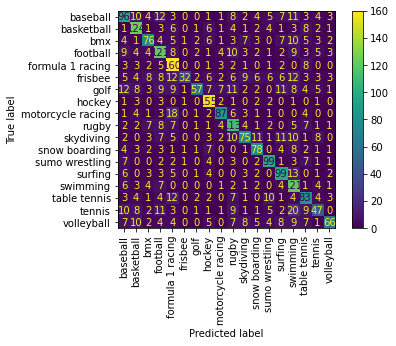

In [136]:
res = svcModel.predict_proba(trainImages)
predicted = np.argmax(res,axis=1)
analysis(predicted,train_labels)

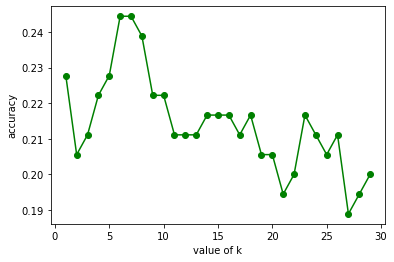

best k: 6


In [148]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

knn_best_acc = 0.0
knn_best_k = 1
knn_accs = []
max_k = 30
for k in range(1, max_k):
    knnModel = KNeighborsClassifier(n_neighbors=k)
    knnModel.fit(trainImages,train_labels)
    res = knnModel.predict_proba(testImages)
    predicted = np.argmax(res,axis=1)
    knn_acc = accuracy_score(test_labels, predicted)
    knn_accs.append(knn_acc)
    if knn_acc > knn_best_acc:
        knn_best_acc = knn_acc
        knn_best_k = k
fig, ax = plt.subplots()
x = np.arange(1, max_k, 1)
ax.plot(x, knn_accs, 'go-')
plt.xlabel('value of k')
plt.ylabel('accuracy')
plt.show()
print('best k:',knn_best_k)

In [142]:
from sklearn.neighbors import KNeighborsClassifier
n_neigh = knn_best_k
knnModel = KNeighborsClassifier(n_neighbors=n_neigh)
knnModel.fit(trainImages,train_labels)

KNeighborsClassifier(n_neighbors=6)

Accuracy: 0.24444444444444444
Precision: 0.32922482704912914
Recall: 0.24444444444444444


D:\Programmi\anaconda\envs\ml_ai\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programmi\anaconda\envs\ml_ai\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programmi\anaconda\envs\ml_ai\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programmi\anaconda\envs\ml_ai\lib\site-pa

                   precision    recall  f1-score   support

         baseball      0.143     0.200     0.167        10
       basketball      0.333     0.100     0.154        10
              bmx      0.250     0.100     0.143        10
         football      0.273     0.300     0.286        10
 formula 1 racing      0.333     0.300     0.316        10
          frisbee      0.222     0.200     0.211        10
             golf      0.400     0.200     0.267        10
           hockey      1.000     0.400     0.571        10
motorcycle racing      1.000     0.300     0.462        10
            rugby      0.000     0.000     0.000        10
        skydiving      0.102     0.500     0.169        10
    snow boarding      0.000     0.000     0.000        10
   sumo wrestling      0.429     0.300     0.353        10
          surfing      0.636     0.700     0.667        10
         swimming      0.167     0.300     0.214        10
     table tennis      0.500     0.100     0.167       

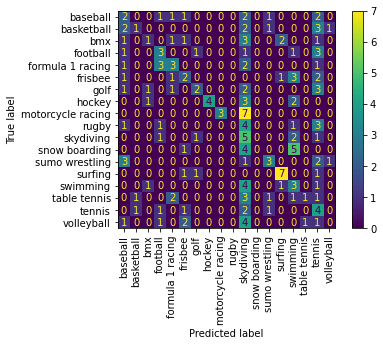

In [144]:
res = knnModel.predict_proba(testImages)
predicted = np.argmax(res,axis=1)
analysis(predicted,test_labels)

Accuracy: 0.31911013858497445
Precision: 0.48453327290034637
Recall: 0.31911013858497445
                   precision    recall  f1-score   support

         baseball      0.231     0.425     0.300       174
       basketball      0.464     0.308     0.370       169
              bmx      0.425     0.243     0.309       140
         football      0.286     0.272     0.279       191
 formula 1 racing      0.524     0.398     0.452       191
          frisbee      0.323     0.241     0.276       133
             golf      0.521     0.236     0.325       157
           hockey      0.889     0.186     0.308       172
motorcycle racing      0.778     0.265     0.395       132
            rugby      0.786     0.066     0.122       166
        skydiving      0.154     0.691     0.252       149
    snow boarding      0.684     0.222     0.335       117
   sumo wrestling      0.667     0.316     0.429       133
          surfing      0.455     0.535     0.492       142
         swimming      0.

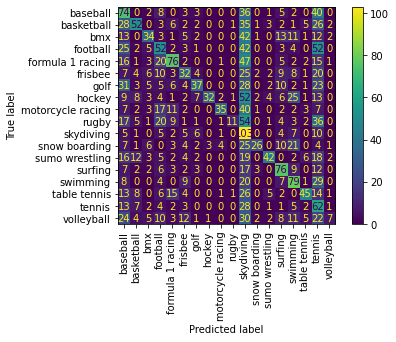

In [143]:
res = knnModel.predict_proba(trainImages)
predicted = np.argmax(res,axis=1)
analysis(predicted,train_labels)